-----------------------------------------------------------------------------------------
Formatação dataset emoUERJ (https://zenodo.org/records/5427549) para um DataFrame

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install pandas

In [116]:
from os import listdir
from os.path import isfile, join
import pandas as pd

data = "emoUERJ"
train_data_dir = f'./datasets/{data}/'
label_index_in_filename = 3 + len(train_data_dir)
label_dict = {'n':'neutro', 'a':'raiva', 'h': 'felicidade', 's':'tristeza'}

train_audio_files = [f for f in listdir(train_data_dir) if isfile(join(train_data_dir, f))]

data_list = []
df_data = []
for file in train_audio_files:
  filename = file.replace('.wav','')
  if "aug1" not in filename:
    label_from_filename = filename[label_index_in_filename - len(train_data_dir)]
    data_list.append([file, label_dict[label_from_filename]])

df_data = pd.DataFrame(data_list)
df_data.columns = ['file','label']

-----------------------------------------------------------------------------------------
Data Augmentation

In [ ]:
%pip install audiomentations
%pip install librosa
%pip install soundfile
%pip install audiomentations
%pip install matplotlib

In [6]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import soundfile as sf
import librosa

# Definição das variações aplicadas
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=1),
    TimeStretch(min_rate=0.8, max_rate=1, p=1),
    PitchShift(min_semitones=-2, max_semitones=2, p=1),
])

Visualizar o efeito em uma amostra:

In [ ]:
import matplotlib.pyplot as plt

signal, sr = librosa.load("./datasets/emoUERJ/m01a01.wav", sr=None)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=signal, sample_rate=sr)

# Normalize the signal to the range [-1, 1]
signal_normalized = librosa.util.normalize(augmented_samples)

# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal, sr=sr, color="blue")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Plot the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(signal_normalized, sr=sr, color="blue")
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Salvar em um .wav para ouvir:

In [ ]:
# Specify the file path
file_path = "augm_example.wav"

# Save the signal as a WAV file
sf.write(file_path, signal_normalized, sr)

Aplicar em todo o dataset:

In [19]:
augmented_data_list = []
for index, row in df_data.iterrows():
  wav_path = train_data_dir + row['file']
  if "aug" not in wav_path:
    signal, sr = librosa.load(wav_path, sr=None)

    # Aplicar augmentations
    augmented_samples = augment(samples=signal, sample_rate=sr)
    signal_normalized = librosa.util.normalize(augmented_samples)

    file_name = row['file'][:-len(".wav")] + "aug.wav"

    new_wav_path = train_data_dir + file_name
    sf.write(new_wav_path, signal_normalized, sr)
    label_from_filename = wav_path[label_index_in_filename]
    augmented_data_list.append([file_name, label_dict[label_from_filename]])

complete_data_list = data_list + augmented_data_list
df_data = pd.DataFrame(complete_data_list)
df_data.columns = ['file','label']

Visualizar os dados:

In [110]:
df_data

,file,label
0,m01a05_aug.wav,raiva
1,m02a07_aug.wav,raiva
2,m02a07_.wav,raiva
3,m02h08_aug.wav,felicidade
4,m01s12_.wav,tristeza
5,m03n09_aug.wav,neutro
6,m01a05_.wav,raiva
7,m03n09_.wav,neutro
8,m02h08_.wav,felicidade
9,m01s12_aug.wav,tristeza


Visualizar a distribuição de classes:

In [ ]:
# - Instalações (necessário rodar uma vez somente)
%pip install matplotlib

<Axes: >

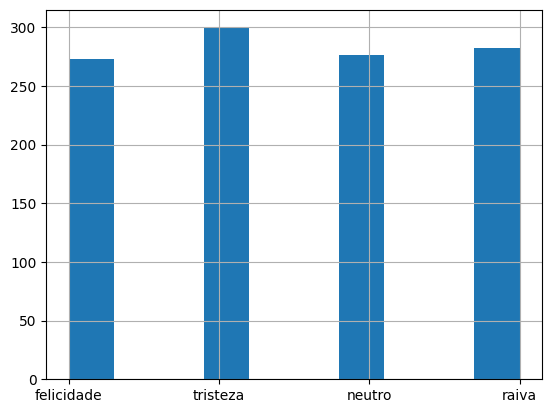

In [5]:
df_data.label.hist()

----------------------------------------------------------------------------------
Extrair features prosódicas (de entonação) com MFCC, Melspec, RMS

Configuração inicial:

In [ ]:
%pip install librosa
!sudo apt-get install sox libsox-fmt-mp3

In [111]:
import librosa
import numpy as np

def format_features(features, sound_filepath):
  mean_features = np.mean(features, axis=1)
  std_features = np.std(features, axis=1)
  max_features = np.max(features, axis=1)
  min_features = np.min(features, axis=1)
  
  features_stat = np.concatenate([mean_features, std_features, max_features, min_features])
  
  columns = [f'Mean_{i}' for i in range(features.shape[0])]
  columns += [f'Std_{i}' for i in range(features.shape[0])]
  columns += [f'Min_{i}' for i in range(features.shape[0])]
  columns += [f'Max_{i}' for i in range(features.shape[0])]
  
  df = pd.DataFrame(columns=columns)
  for i, feat in enumerate(features_stat):
    df.at[0, columns[i]] = feat

  # Adiciona label
  label_from_filename = sound_filepath[label_index_in_filename]
  df['label'] = None
  df.at[0, 'label'] = label_dict[label_from_filename]

  return df

MFCC - tempo médio 0,047s

In [112]:
feature_mode = "mfcc"
n_mfcc = 13
def extract_features(sound_filepath):
  y, sr = librosa.load(sound_filepath, sr=None)
  features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # You can adjust the number of coefficients (n_mfcc)
  return format_features(features, sound_filepath)

Melspec - tempo médio 0,100s

In [63]:
feature_mode = "melspec"
def extract_features(sound_filepath):
  y, sr = librosa.load(sound_filepath, sr=None)
  features = librosa.feature.melspectrogram(y=y, sr=sr)
  return format_features(features, sound_filepath)

RMS - tempo médio 0,089

In [99]:
feature_mode = "rms"
def extract_features(sound_filepath):
  y, sr = librosa.load(sound_filepath, sr=None)
  features = librosa.feature.rms(y=y)
  return format_features(features, sound_filepath)

Exemplo de extração para uma amostra:

In [107]:
extract_features('./datasets/emoUERJ/m01a02.wav')

,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9,...,Max_4,Max_5,Max_6,Max_7,Max_8,Max_9,Max_10,Max_11,Max_12,label
0,-265.234497,114.559395,-42.191963,28.159666,-0.840428,23.10008,-19.811832,-0.583661,5.396158,-8.25098,...,-47.882607,-8.506006,-79.660919,-37.611782,-24.931644,-36.256405,-35.363228,-31.929523,-24.029367,raiva


Extração para todo o dataset:

In [113]:
sample_df_list = []
for index, row in df_data.iterrows():
  wav_file = train_data_dir + row['file']
  print(f"Sample {index}")
  sample_df_features = extract_features(wav_file) # Extração de features
  sample_df_list.append(sample_df_features)

print(f"*** Extraction finished ***")

df_features = pd.concat(sample_df_list).reset_index(drop=True)

df_features

Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
*** Extraction finished ***


,Mean_0,Mean_1,Mean_2,Mean_3,Mean_4,Mean_5,Mean_6,Mean_7,Mean_8,Mean_9,...,Max_4,Max_5,Max_6,Max_7,Max_8,Max_9,Max_10,Max_11,Max_12,label
0,-120.393913,30.2502,5.561484,21.134062,-4.199063,16.027277,-9.624965,-0.634238,-0.423847,-1.58003,...,-50.53867,-21.090796,-48.797859,-32.642796,-28.695499,-30.9832,-30.924585,-25.057455,-22.694229,raiva
1,-121.647614,58.43449,13.796205,15.066666,-5.233464,19.227259,-3.446369,2.731235,-2.744499,-5.531511,...,-52.233871,-6.5942,-39.251282,-29.162357,-31.720974,-38.247475,-32.884602,-27.145241,-41.78627,raiva
2,-270.287964,98.219955,-4.959806,22.185711,-14.9016,29.138012,-11.297945,5.091217,1.444533,-7.959241,...,-55.514488,-7.256014,-55.534325,-35.633297,-27.640062,-38.711315,-42.707489,-31.974157,-52.680679,raiva
3,-135.36586,50.427658,6.758118,2.134413,-3.896539,2.411786,-4.279986,-5.454532,-12.812734,-0.39273,...,-39.790516,-51.45599,-40.13192,-42.451893,-43.393761,-18.685852,-35.254539,-22.283154,-14.217197,felicidade
4,-297.812012,115.534592,-12.671356,32.321941,-1.300084,31.163128,-11.054958,7.515409,1.547294,-4.051042,...,-62.462425,0.0,-48.015541,-24.424984,-29.444477,-33.366722,-41.751991,-28.792614,-24.515873,tristeza
5,-171.868698,101.38118,16.239685,20.962845,7.45484,21.603853,0.411624,6.251538,1.333302,-0.224336,...,-37.756119,-10.891894,-32.383839,-32.383366,-30.564837,-37.607468,-32.147812,-31.569897,-26.814743,neutro
6,-262.205353,68.356712,-11.488959,30.158794,-14.20197,29.044436,-13.452374,5.292688,-1.647442,0.837199,...,-57.200401,-11.958372,-58.405533,-30.083271,-38.739555,-28.646259,-35.601421,-32.788956,-27.164314,raiva
7,-299.404572,132.773972,-6.490292,32.601013,-5.35038,30.300333,-7.869861,8.737933,-0.463208,-2.695093,...,-51.099247,-6.388162,-45.084915,-35.750366,-33.485435,-36.940544,-30.006163,-30.321762,-29.969353,neutro
8,-288.857758,107.592804,-17.641403,22.437815,-14.178369,14.814788,-8.817983,6.887046,-15.312453,-3.738934,...,-43.358231,-42.676418,-51.302429,-35.688549,-61.834694,-31.81506,-30.266457,-39.949989,-21.938438,felicidade
9,-152.296875,55.250423,12.799426,18.197889,14.403983,15.817471,-1.782359,0.917479,0.460692,-4.444612,...,-37.474266,-14.776251,-32.746319,-34.78154,-29.132971,-38.829754,-36.915337,-27.666245,-22.125404,tristeza


Salvar em um .csv:

In [117]:
df_features.to_csv("features/" + train_data_dir[-(len(data)+1):-1] + f'_features/aug_{feature_mode}_features.csv',index=False)